In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

In [2]:
PATH = os.path.join(os.path.dirname('C:/Material/Sem5/AI/Research/TLT'))

train_dir = os.path.join(PATH, 'C:/Material/Sem5/AI/Research/TLT/train')
validation_dir = os.path.join(PATH, 'C:/Material/Sem5/AI/Research/TLT/test')

BATCH_SIZE = 32
IMG_SIZE = (160, 160)

train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)

Found 5536 files belonging to 2 classes.


In [3]:
validation_dataset = tf.keras.utils.image_dataset_from_directory(validation_dir,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)

Found 2373 files belonging to 2 classes.


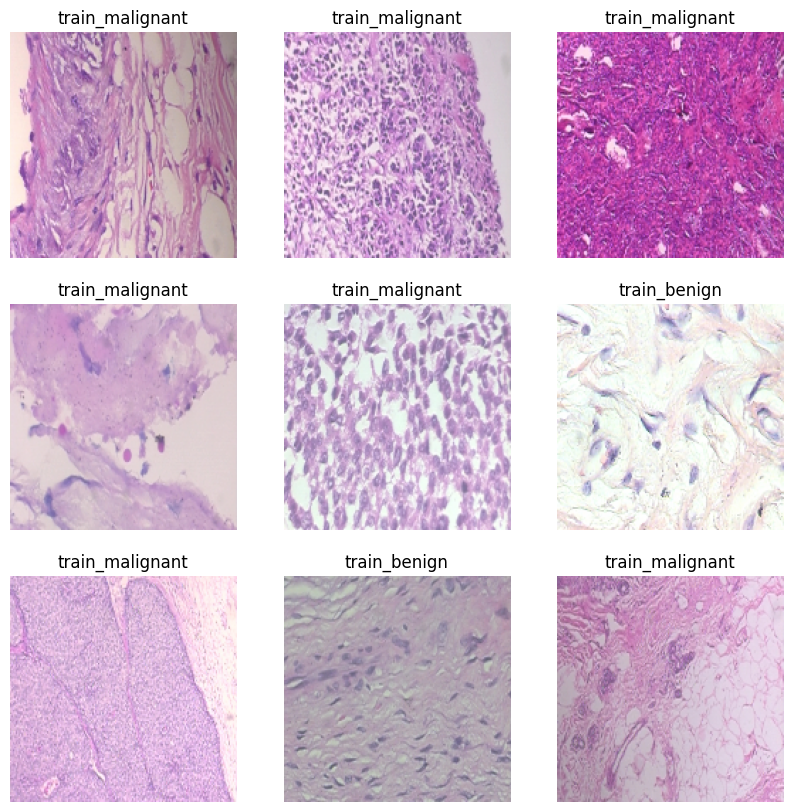

In [4]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [5]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

In [6]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 60
Number of test batches: 15


In [7]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [8]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

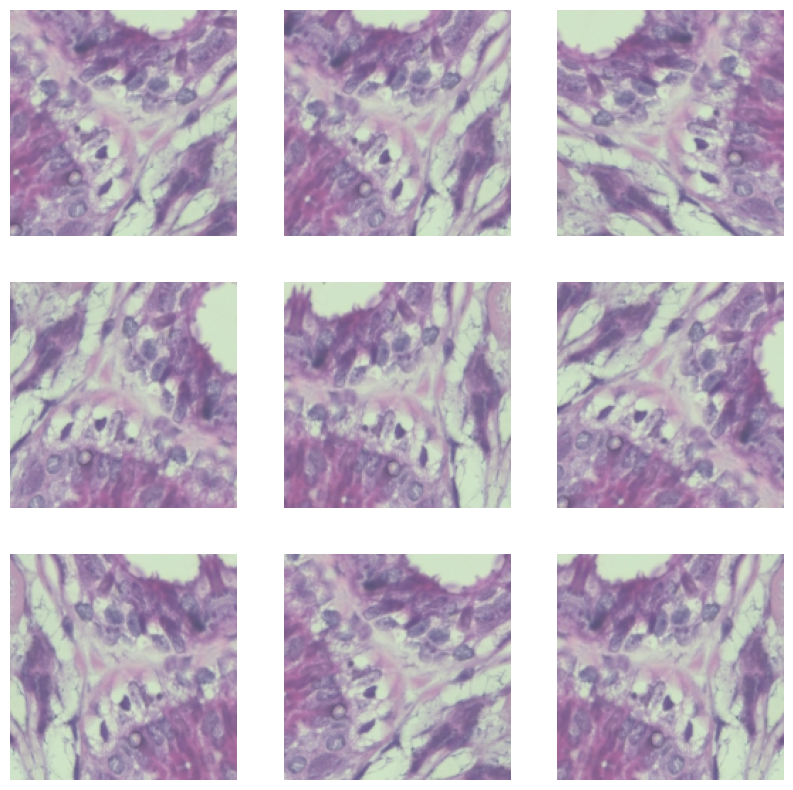

In [9]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

In [10]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [11]:
rescale = tf.keras.layers.Rescaling(1./127.5, offset=-1)

In [12]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

In [13]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 1280)


In [14]:
base_model.trainable = False

In [15]:
# Let's take a look at the base model architecture
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 160, 160, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 80, 80, 32)           864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 80, 80, 32)           128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 80, 80, 32)           0         ['bn_Conv1[

In [16]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [17]:
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


In [18]:
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [19]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 160, 160, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambd  (None, 160, 160, 3)       0         
 a)                                                              
                                                                 
 tf.math.subtract (TFOpLamb  (None, 160, 160, 3)       0         
 da)                                                             
                                                                 
 mobilenetv2_1.00_160 (Func  (None, 5, 5, 1280)        2257984   
 tional)                                                         
                                                             

In [20]:
len(model.trainable_variables)

2

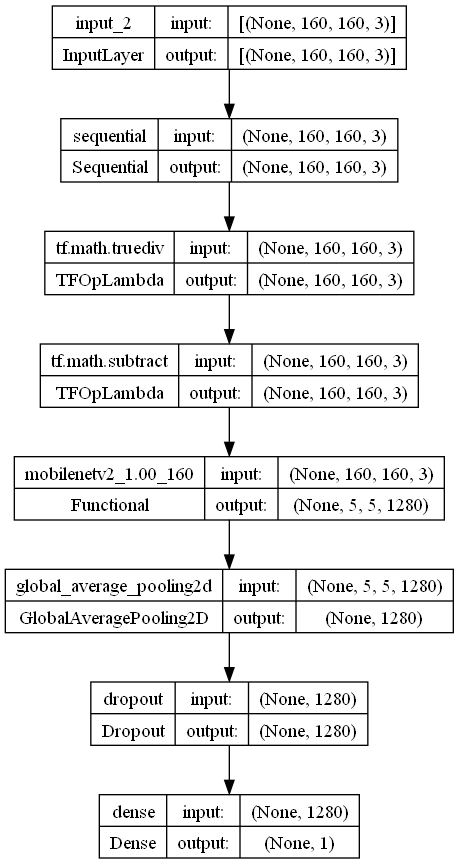

In [21]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [22]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=[tf.keras.metrics.BinaryAccuracy(threshold=0, name='accuracy')])

In [23]:
initial_epochs = 10

loss0, accuracy0 = model.evaluate(validation_dataset)

60/60 [==============================] - 10s 152ms/step - loss: 0.8090 - accuracy: 0.4654


In [24]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 0.81
initial accuracy: 0.47


In [25]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/10


173/173 [==============================] - 43s 236ms/step - loss: 0.6880 - accuracy: 0.6261 - val_loss: 0.6261 - val_accuracy: 0.6741
Epoch 2/10
173/173 [==============================] - 67s 386ms/step - loss: 0.6315 - accuracy: 0.6676 - val_loss: 0.5902 - val_accuracy: 0.6984
Epoch 3/10
173/173 [==============================] - 67s 387ms/step - loss: 0.6056 - accuracy: 0.6848 - val_loss: 0.5560 - val_accuracy: 0.7195
Epoch 4/10
173/173 [==============================] - 66s 380ms/step - loss: 0.5937 - accuracy: 0.6859 - val_loss: 0.5513 - val_accuracy: 0.7126
Epoch 5/10
173/173 [==============================] - 46s 265ms/step - loss: 0.5643 - accuracy: 0.7171 - val_loss: 0.5291 - val_accuracy: 0.7348
Epoch 6/10
173/173 [==============================] - 39s 226ms/step - loss: 0.5633 - accuracy: 0.7110 - val_loss: 0.5174 - val_accuracy: 0.7427
Epoch 7/10
173/173 [==============================] - 40s 228ms/step - loss: 0.5518 - accuracy: 0.7169 - val_loss: 0.5090 - val_accuracy: 0.7

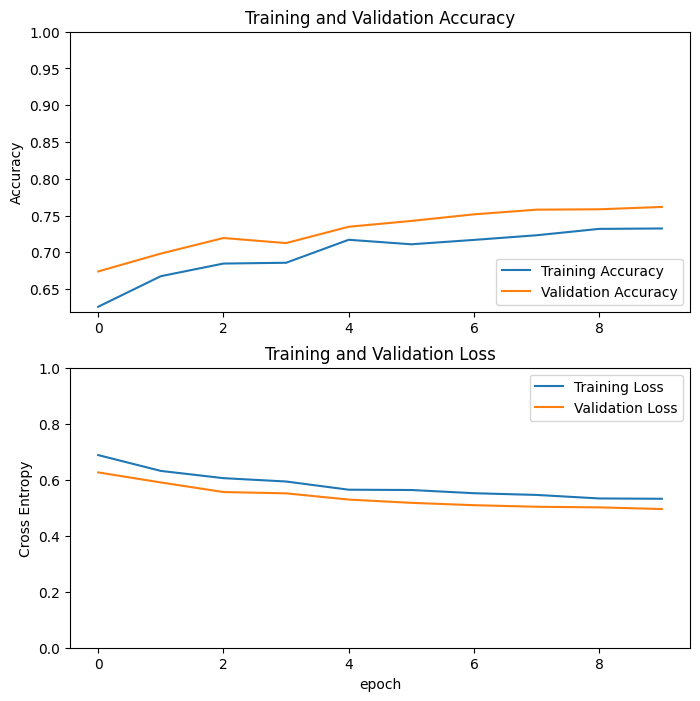

In [26]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [27]:
base_model.trainable = True

In [28]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  154


In [29]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=[tf.keras.metrics.BinaryAccuracy(threshold=0, name='accuracy')])

In [30]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 160, 160, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambd  (None, 160, 160, 3)       0         
 a)                                                              
                                                                 
 tf.math.subtract (TFOpLamb  (None, 160, 160, 3)       0         
 da)                                                             
                                                                 
 mobilenetv2_1.00_160 (Func  (None, 5, 5, 1280)        2257984   
 tional)                                                         
                                                             

In [31]:
len(model.trainable_variables)

56

In [32]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

Epoch 10/20


173/173 [==============================] - 54s 298ms/step - loss: 0.5053 - accuracy: 0.7565 - val_loss: 0.4539 - val_accuracy: 0.7934
Epoch 11/20
173/173 [==============================] - 50s 290ms/step - loss: 0.4363 - accuracy: 0.7914 - val_loss: 0.4117 - val_accuracy: 0.8199
Epoch 12/20
173/173 [==============================] - 51s 291ms/step - loss: 0.4003 - accuracy: 0.8087 - val_loss: 0.4401 - val_accuracy: 0.7956
Epoch 13/20
173/173 [==============================] - 51s 292ms/step - loss: 0.3785 - accuracy: 0.8279 - val_loss: 0.3678 - val_accuracy: 0.8373
Epoch 14/20
173/173 [==============================] - 51s 291ms/step - loss: 0.3400 - accuracy: 0.8537 - val_loss: 0.3672 - val_accuracy: 0.8378
Epoch 15/20
173/173 [==============================] - 50s 290ms/step - loss: 0.3233 - accuracy: 0.8624 - val_loss: 0.4165 - val_accuracy: 0.8082
Epoch 16/20
173/173 [==============================] - 51s 291ms/step - loss: 0.3057 - accuracy: 0.8663 - val_loss: 0.3076 - val_accurac

In [33]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

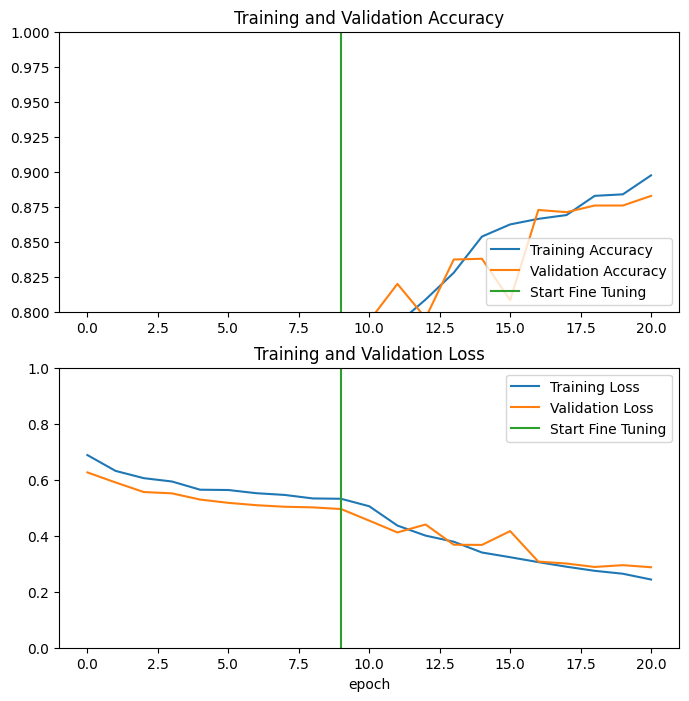

In [34]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [35]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

15/15 [==============================] - 3s 165ms/step - loss: 0.2773 - accuracy: 0.8854
Test accuracy : 0.8854166865348816


Predictions:
 [1 1 1 0 1 1 1 1 0 0 1 1 1 1 1 1 0 1 0 1 0 1 1 0 1 1 1 0 1 1 1 1]
Labels:
 [1 1 1 0 1 1 1 1 0 0 1 0 1 1 1 0 0 1 0 1 0 1 1 0 1 1 1 0 1 1 1 1]


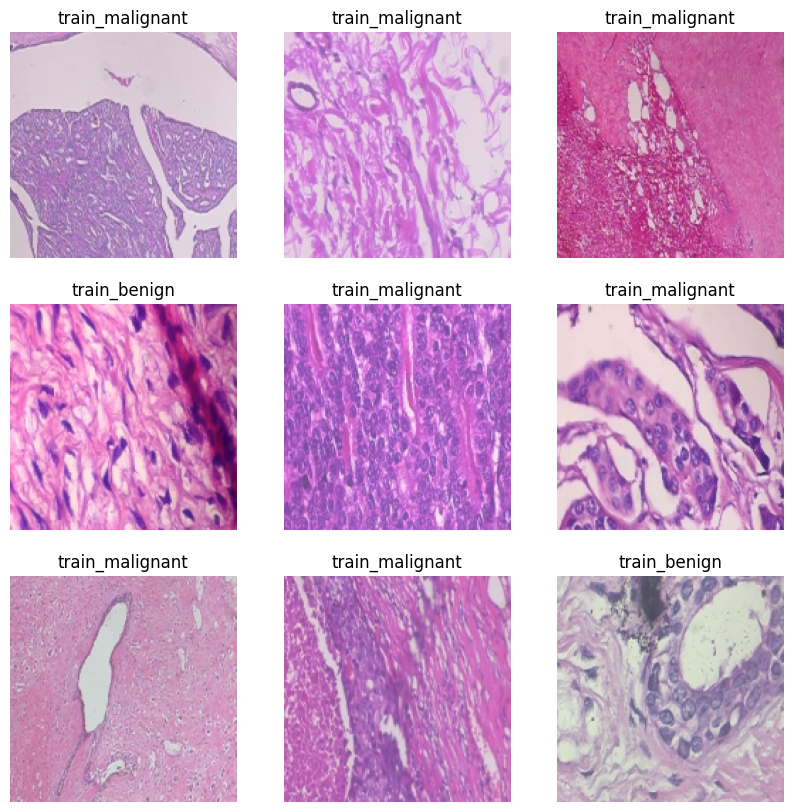

In [36]:
# Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")

In [37]:
model.save('TF_TuT')

INFO:tensorflow:Assets written to: TF_TuT\assets


INFO:tensorflow:Assets written to: TF_TuT\assets


In [43]:
import tensorflow as tf
from tensorflow.keras.models import load_model
import numpy as np
from PIL import Image

# Load the pre-trained model.
model = load_model('TF_TuT')

# Read the image.
image = Image.open('1.jpg')

# Resize the image.
image = image.resize((160, 160))

# Convert the image to a numpy array.
image = np.array(image)

# Reshape the image to the expected shape.
image = image.reshape(-1, 160, 160, 3)

# Make predictions.
predictions = model.predict(image)

# Print the predictions.
print(predictions)



1/1 [==============================] - 0s 432ms/step
[[5.249326]]
